In [1]:
print("strawberry")

strawberry


In [ ]:
import torch
import numpy as np

# dataset
from twaidata.torchdatasets.in_ram_ds import MRISegmentation2DDataset, MRISegmentation3DDataset
from torch.utils.data import DataLoader, random_split, ConcatDataset

# model
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_DDU import HyperMapp3rDDU
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_SSN import HyperMapp3rSSN


# augmentation and pretrain processing
from trustworthai.utils.augmentation.standard_transforms import RandomFlip, GaussianBlur, GaussianNoise, \
                                                            RandomResizeCrop, RandomAffine, \
                                                            NormalizeImg, PairedCompose, LabelSelect, \
                                                            PairedCentreCrop, CropZDim
# loss function
from trustworthai.utils.losses_and_metrics.per_individual_losses import (
    dice_loss,
    log_cosh_dice_loss,
    TverskyLoss,
    FocalTverskyLoss,
    DiceLossMetric
)
from torch.nn import BCELoss, MSELoss, BCEWithLogitsLoss

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import pytorch_lightning as pl

# misc
import os
import torch
import matplotlib.pyplot as plt
import torch
from torchinfo import summary

### Set the seed

In [ ]:
seed = 3407
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### define datasets and dataloaders

In [ ]:
is3D = False

In [ ]:
#root_dir = "/disk/scratch/s2208943/ipdis/preprep/out_data/collated/"
root_dir = "/media/benp/NVMEspare/datasets/preprocessing_attempts/local_results/collated/"
wmh_dir = root_dir + "WMH_challenge_dataset/"
ed_dir = root_dir + "EdData/"

In [ ]:
# domains = [
#             wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
#           ]

# domains = [
#             wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
#           ] + [
#             ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
#           ]


domains = [
            ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
          ]

In [ ]:
# augmentation definintion
def get_transforms(is_3D):
    transforms = [
        LabelSelect(label_id=1),
        RandomFlip(p=0.5, orientation="horizontal"),
        # GaussianBlur(p=0.5, kernel_size=7, sigma=(.1, 1.5)),
        # GaussianNoise(p=0.2, mean=0, sigma=0.2),
        # RandomAffine(p=0.2, shear=(.1,3.)),
        # RandomAffine(p=0.2, degrees=5),
        #RandomResizeCrop(p=1., scale=(0.6, 1.), ratio=(3./4., 4./3.))
        RandomResizeCrop(p=1., scale=(0.3, 0.5), ratio=(3./4., 4./3.)) # ssn
    ]
    if not is_3D:
        transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
        return PairedCompose(transforms)
    else:
        transforms.append(CropZDim(size=32, minimum=0, maximum=-1))
        transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
        return PairedCompose(transforms)

In [ ]:
# function to do train validate test split
test_proportion = 0.1
validation_proportion = 0.2

def train_val_test_split(dataset, val_prop, test_prop, seed):
    # I think the sklearn version might be prefereable for determinism and things
    # but that involves fiddling with the dataset implementation I think....
    size = len(dataset)
    test_size = int(test_prop*size) 
    val_size = int(val_prop*size)
    train_size = size - val_size - test_size
    train, val, test = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(seed))
    return train, val, test

In [ ]:
# load datasets
# this step is quite slow, all the data is being loaded into memory
if is3D:
    datasets_domains = [MRISegmentation3DDataset(root_dir, domain, transforms=get_transforms(is_3D=True)) for domain in domains]
else:
    datasets_domains = [MRISegmentation2DDataset(root_dir, domain, transforms=get_transforms(is_3D=False)) for domain in domains]

# split into train, val test datasets
datasets = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains]

# concat the train val test datsets
train_dataset = ConcatDataset([ds[0] for ds in datasets])
val_dataset = ConcatDataset([ds[1] for ds in datasets])
test_dataset = ConcatDataset([ds[2] for ds in datasets])

In [ ]:
len(train_dataset), len(val_dataset), len(test_dataset)

In [ ]:
# define dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

In [ ]:
import torch
import torch.nn as nn
from trustworthai.models.uq_models.drop_UNet import normalization_layer
import torch.nn.functional as F
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
import torch.distributions as td
from typing import Tuple


def get_conv_func(dims, transpose=False):
    # determine convolution func
        if dims == 2:
            if transpose:
                return nn.ConvTranspose2d
            else:
                return nn.Conv2d
        elif dims == 3:
            if transpose:
                return nn.ConvTranspose3d
            else:
                return nn.Conv3d
        else:
            raise ValueError(f"values of dims of 2 or 3 (2D or 2D conv) are supported only, not {dims}")
            
def get_dropout_func(dims):
    if dims == 2:
        return nn.Dropout2d
    if dims == 3:
        return nn.Dropout3d
    else:
        return nn.Dropout

class ReshapedDistribution(td.Distribution):
    def __init__(self, base_distribution: td.Distribution, new_event_shape: Tuple[int, ...]):
        super().__init__(batch_shape=base_distribution.batch_shape, event_shape=new_event_shape, validate_args=False)
        self.base_distribution = base_distribution
        self.new_shape = base_distribution.batch_shape + new_event_shape
        
        #print("base distribution: ", self.base_distribution)

    @property
    def support(self):
        return self.base_distribution.support

    @property
    def arg_constraints(self):
        return self.base_distribution.arg_constraints()

    @property
    def mean(self):
        return self.base_distribution.mean.view(self.new_shape)

    @property
    def variance(self):
        return self.base_distribution.variance.view(self.new_shape)

    def rsample(self, sample_shape=torch.Size()):
        return self.base_distribution.rsample(sample_shape).view(sample_shape + self.new_shape)

    def log_prob(self, value):
        return self.base_distribution.log_prob(value.view(self.batch_shape + (-1,)))

    def entropy(self):
        return self.base_distribution.entropy()    
    
class HyperMapp3rSSN2(HyperMapp3r):
    def __init__(self, dims=3,
                 in_channels=3,
                 out_channels=1,
                 encoder_features=[16, 32, 64, 128, 256],
                 decoder_features=[128, 64, 32, 16],
                 softmax=True,
                 up_res_blocks=False,
                 block_params={
                     "dropout_p":0.1,
                     "norm_type":"in", 
                     "dropout_both_layers":False,
                 },
                 ssn_rank = 10,
                 ssn_epsilon=1e-5,
                 ssn_diagonal=False
                ):
        super().__init__(dims=dims,
                 in_channels=in_channels,
                 out_channels=decoder_features[-1], # last layer of just keeps number of nodes fixed this time
                 encoder_features=encoder_features,
                 decoder_features=decoder_features,
                 softmax=False,
                 up_res_blocks=up_res_blocks,
                 block_params=block_params)
        
        print("WARNING: this model assumes that the input to the model contains the brain mask in the first channel!")
        conv_func = get_conv_func(dims, transpose=False)
        self.ssn_rank = ssn_rank
        self.ssn_diagonal = ssn_diagonal
        self.ssn_epsilon = ssn_epsilon
        self.ssn_num_classes = out_channels
        
        self.lrelu = nn.LeakyReLU(0.01)
        
        self.mean_l = conv_func(decoder_features[-1], out_channels, kernel_size = (1,) *  dims, padding='same')
        self.log_cov_diag_l = conv_func(decoder_features[-1], out_channels, kernel_size = (1,) * dims, padding='same')
        self.cov_factor_l = conv_func(decoder_features[-1], out_channels * ssn_rank, kernel_size = (1,) * dims, padding='same')

    def forward(self, x):
        logits = self.lrelu(super().forward(x))
        if torch.sum(torch.isnan(logits)) > 0:
            print("NAN 1", torch.sum(torch.isnan(logits)))
        batch_size = logits.shape[0]
        event_shape = (self.ssn_num_classes,) + logits.shape[2:]
        
        mean = self.mean_l(logits)
        mean = mean.view((batch_size, -1))
        
        cov_diag = self.log_cov_diag_l(logits).exp() + self.ssn_epsilon
        cov_diag = cov_diag.view((batch_size, -1))
        
        cov_factor = self.cov_factor_l(logits)
        cov_factor = cov_factor.view((batch_size, self.ssn_rank, self.ssn_num_classes, -1))
        cov_factor = cov_factor.flatten(2,3)
        cov_factor = cov_factor.transpose(1,2)
        if torch.sum(torch.isnan(mean)) > 0:
            print("NAN 2")
        if torch.sum(torch.isnan(cov_diag)) > 0:
            print("NAN 3")
        if torch.sum(torch.isnan(cov_factor)) > 0:
            print("NAN 4")
        
        # covariance tends to blow up to infinity, hence set to 0 outside the ROI
        mask = x[:,1]
        mask = mask.unsqueeze(1).expand((batch_size, self.ssn_num_classes) + mask.shape[1:]).reshape(batch_size, -1)
        cov_factor = cov_factor * mask.unsqueeze(-1)
        cov_diag = cov_diag * mask + self.ssn_epsilon
        
        if torch.sum(torch.isnan(mask)) > 0:
            print("NAN 5")
        if torch.sum(torch.isnan(cov_factor)) > 0:
            print("NAN 6")
        if torch.sum(torch.isnan(cov_diag)) > 0:
            print("NAN 7")
        
        if self.ssn_diagonal:
            base_distribution = td.Independent(td.Normal(loc=mean, scale=torch.sqrt(cov_diag)), 1)
        else:
            try:
                base_distribution = td.LowRankMultivariateNormal(loc=mean, cov_factor=cov_factor, cov_diag=cov_diag)
                #print("using multivariate normal!")
            except Exception as e:
                print("was thrown: ", e)
                print('hmm: Covariance became non invertible using independent normals for this batch!')
                print("cov diag okay: ", torch.sum(cov_diag <=0))
                print("sqrt cov diag okay: ", torch.sum(torch.sqrt(cov_diag) <=0))
                
                try:
                    base_distribution = td.Independent(td.Normal(loc=mean, scale=torch.sqrt(cov_diag)),1)
                except Exception as e:
                    print("second fail: ", e)
                    print(torch.min(torch.sqrt(cov_diag), torch.max(torch.sqrt(cov_diag))))
        
        distribution = ReshapedDistribution(base_distribution, event_shape)
        
        shape = (batch_size,) + event_shape
        logit_mean_view = mean.view(shape).detach()
        cov_diag_view = cov_diag.view(shape).detach()
        cov_factor_view = cov_factor.transpose(2,1).view((batch_size, self.ssn_num_classes * self.ssn_rank) + event_shape[1:]).detach()
        
        
        output_dict = {
            'logit_mean':logit_mean_view,
            'cov_diag':cov_diag_view,
            'cov_factor':cov_factor_view,
            'distribution':distribution,
        }
        
        return output_dict

### setup model

In [ ]:
in_channels = 3
out_channels = 1

if is3D:
    pass
else:
    # encoder_features=[16, 32, 64, 128, 256] # orig: [16, 32, 64, 128, 256]
    # decoder_features=encoder_features[::-1][1:]
#     model = HyperMapp3r(dims=2,
#                  in_channels=3,
#                  out_channels=2,
#                  encoder_features=[16, 32, 64, 128, 256],
#                  decoder_features=[128, 64, 32, 16],
#                  softmax=False,
#                  up_res_blocks=False,
#                  block_params={
#                      "dropout_p":0.1,
#                      "norm_type":"in", 
#                      "dropout_both_layers":False,
#                  }
#                    )
    
    # model = HyperMapp3rDDU(dims=2,
    #              in_channels=3,
    #              out_channels=2,
    #              encoder_features=[16, 32, 64, 128, 256],
    #              decoder_features=[128, 64, 32, 16],
    #              softmax=False,
    #              up_res_blocks=True,
    #              n_power_iterations=3, 
    #              eps=1e-12,
    #              block_params={
    #                  "dropout_p":0.1,
    #                  "norm_type":"in", 
    #                  "dropout_both_layers":False,
    #              }
    #                )
    
    model = HyperMapp3rSSN2(dims=2,
                 in_channels=3,
                 out_channels=2,
                 encoder_features=[16, 32, 64, 128, 256],
                 decoder_features=[128, 64, 32, 16],
                 softmax=True,
                 up_res_blocks=False,
                 block_params={
                     "dropout_p":0.1,
                     "norm_type":"in", 
                     "dropout_both_layers":False,
                 },
                 ssn_rank = 10,
                 ssn_epsilon=1e-5,
                 ssn_diagonal=False)
    
    #optimizer_params={"lr":2e-3}
    #lr_scheduler_params={"step_size":20, "gamma":0.1}
    optimizer_params={"lr":2e-3, "momentum":0.6}
    optimizer = torch.optim.RMSprop
    lr_scheduler_params={"milestones":[10,100,200], "gamma":0.5}
    lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR


In [ ]:
summary(model)

In [ ]:
#model.load_state_dict(torch.load( "ssn_trained_no_wrapper_class.ckpt"))

In [ ]:
import pytorch_lightning as pl

import torch
import torch.nn as nn
import torch.nn.functional as F

class StandardLitModelWrapper(pl.LightningModule):
    def __init__(self, model, loss=F.cross_entropy, logging_metric=None, optimizer_params={"lr":1e-3}, lr_scheduler_params={"step_size":30, "gamma":0.1}, is_uq_model=False,
                optimizer_constructor=None, lr_scheduler_constructor=None):
        super().__init__()
        self.model = model
        self.loss = loss
        self.logging_metric_train = logging_metric()
        self.logging_metric_val = logging_metric()
        self.optim_params = optimizer_params
        self.lr_scheduler_params = lr_scheduler_params
        self.is_uq_model = False
        self.optimizer_constructor = optimizer_constructor
        self.lr_scheduler_constructor = lr_scheduler_constructor

        
    def forward(self, x, **kwargs):
        return self.model(x, **kwargs)
    
    def configure_optimizers(self):
        # optimizer and schedulers go in the configure optimizers hook
        if self.optimizer_constructor:
            optimizer = self.optimizer_constructor(self.parameters(), **self.optim_params)
        else:
            optimizer = torch.optim.Adam(self.parameters(), **self.optim_params)
        
        if self.lr_scheduler_constructor:
            lr_scheduler = self.lr_scheduler_constructor(optimizer, **self.lr_scheduler_params)
        else:
            lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, **self.lr_scheduler_params)
        
        return [optimizer], [lr_scheduler]
    
    def training_step(self, batch, batch_idx):
        """
        lightning automates the training loop, 
        does epoch, back_tracking, optimizers and schedulers,
        and metric reduction.
        we just define how we want to process a single batch. 
        we can optionally pass optimizer_idx if we want to define multiple optimizers within the configure_optimizers
        hook, and I presume we can add our own parameters also to functions?
        """
        
        if self.is_uq_model:
            self.model.set_applyfunc(True)
        
        X, y = batch
        y_hat = self(X)
        loss = self.loss(y_hat, y)
        
        # metrics 
        if self.logging_metric_train:
            self.logging_metric_train(y_hat, y)
            self.log(f"train_metric", self.logging_metric_train, on_step=True, on_epoch=False, prog_bar=True)
        self.log("train_loss", loss)
        
        return loss
    
#     def training_epoch_end(self, outs):
#         self.log('train_metric_epoch', self.logging_metric_train.compute())
        
#     def validation_epoch_end(self, outs):
#         self.log('val_metric_epoch', self.logging_metric_val.compute())
    
    def validation_step(self, batch, batch_idx):
        """
        note: call trainer.validate() automatically loads the best checkpoint if checkpointing was enabled during fitting
        well yes I want to enable checkpointing but will deal with that later.
        also it does stuff like model.eval() and torch.no_grad() automatically which is nice.
        I will need a custom eval thing to do my dropout estimation but can solve that later too.
        """
        if self.is_uq_model:
            self.model.set_applyfunc(False)
        
        X, y = batch
        y_hat = self(X)
        val_loss = self.loss(y_hat, y)
        
        if self.logging_metric_val:
            self.logging_metric_val(y_hat, y)
            self.log(f"val_metric", self.logging_metric_val, on_step=True, on_epoch=True, prog_bar=True)
        self.log("val_loss", val_loss)
        
    def test_step(self, batch, batch_idx):
        """
        we would need to directly call this function using the trainer
        """
        
        if self.is_uq_model:
            self.model.set_applyfunc(False)
        
        X, y = batch
        y_hat = self(X)
        test_loss = self.loss(y_hat, y)
        self.log("test_loss", test_loss)
        
    def predict_step(self, batch, batch_idx):
        """
        just for making predictions as opposed to collecting metrics etc
        note to use this, we just call .predict(dataloader) and it then automates the look
        these functions are for a single batch. Nice.
        """
        X, y = batch
        pred = self(X)
        return pred

In [ ]:
# summary(model, (1, 3, 128, 128))

In [ ]:
#loss = dice_loss
#loss = torch.nn.CrossEntropyLoss(weight=torch.Tensor([0.968, 0.032]))
#loss = FocalLoss(gamma=1., reduction='mean', alpha=torch.Tensor([1-0.968, 1-0.032]))
#loss = log_cosh_dice_loss
#loss = TverskyLoss(beta=0.7)
#loss = FocalTverskyLoss(beta=0.7, gamma=0.8)

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import math


class StochasticSegmentationNetworkLossMCIntegral(nn.Module):
    def __init__(self, num_mc_samples: int = 1):
        super().__init__()
        self.num_mc_samples = num_mc_samples

    @staticmethod
    def fixed_re_parametrization_trick(dist, num_samples):
        assert num_samples % 2 == 0
        samples = dist.rsample((num_samples // 2,))
        mean = dist.mean.unsqueeze(0)
        samples = samples - mean
        return torch.cat([samples, -samples]) + mean

    def forward(self, result_dict, target, **kwargs):
        logits = result_dict['logit_mean']
        distribution = result_dict['distribution']
        
        batch_size = logits.shape[0]
        num_classes = logits.shape[1]
        assert num_classes >= 2  # not implemented for binary case with implied background
        # logit_sample = distribution.rsample((self.num_mc_samples,))
        logit_sample = self.fixed_re_parametrization_trick(distribution, self.num_mc_samples)
        target = target.unsqueeze(1)
        target = target.expand((self.num_mc_samples,) + target.shape)

        flat_size = self.num_mc_samples * batch_size
        logit_sample = logit_sample.view((flat_size, num_classes, -1))
        target = target.reshape((flat_size, -1))

        log_prob = -F.cross_entropy(logit_sample, target, reduction='none').view((self.num_mc_samples, batch_size, -1))
        loglikelihood = torch.mean(torch.logsumexp(torch.sum(log_prob, dim=-1), dim=0) - math.log(self.num_mc_samples))
        loss = -loglikelihood
        return loss

In [ ]:
def fixed_re_parametrization_trick(dist, num_samples):
        assert num_samples % 2 == 0
        samples = dist.rsample((num_samples // 2,))
        mean = dist.mean.unsqueeze(0)
        samples = samples - mean
        return torch.cat([samples, -samples]) + mean


class SsnNetworkMeanLossWrapper(nn.Module):
    def __init__(self, loss_func):
        super().__init__()
        self.loss = loss_func
    def forward(self, result_dict, target):
        mean = result_dict['logit_mean']
        return self.loss(mean, target)
    
class SsnNetworkSampleLossWrapper(nn.Module):
    def __init__(self, loss_func, samples=10):
        super().__init__()
        self.loss = loss_func
        self.samples = samples
    def forward(self, result_dict, target):
        samples = fixed_re_parametrization_trick(result_dict['distribution'], self.samples).to(target.device)
        loss = 0
        for s in samples:
            loss += self.loss(s, target)
        return loss / self.samples
        #return torch.mean(torch.Tensor(losses))

In [ ]:
class SsnDiceMetricWrapper(DiceLossMetric):

    def update(self, preds_dict, target: torch.Tensor):
        super().update(preds_dict['logit_mean'], target)

    def compute(self):
        return super().compute()

In [ ]:
ssn_diceloss = SsnNetworkSampleLossWrapper(dice_loss)# SsnNetworkMeanLossWrapper(dice_loss)
mc_loss = StochasticSegmentationNetworkLossMCIntegral(num_mc_samples=10)

def double_loss(outs, target):
    return ssn_diceloss(outs, target) * 10 + mc_loss(outs, target) * 0.01

In [ ]:
# loss = StochasticSegmentationNetworkLossMCIntegral(num_mc_samples=10)
# loss = SsnNetworkSampleLossWrapper(dice_loss)
loss = double_loss

In [ ]:
#optimizer_params={"lr":2e-4, "momentum":0.6}
optimizer_params={"lr":1e-3}
optimizer = torch.optim.Adam
lr_scheduler_params={"milestones":[100,200], "gamma":0.5}
lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR

In [ ]:
model = StandardLitModelWrapper(model, loss, 
                                logging_metric=SsnDiceMetricWrapper,
                                optimizer_params=optimizer_params,
                                lr_scheduler_params=lr_scheduler_params,
                                is_uq_model=False,
                                optimizer_constructor=optimizer,
                                lr_scheduler_constructor=lr_scheduler_constructor
                               )

In [ ]:
checkpoint_dir = "./lightning_logs"
strategy = None
# strategy = "deepspeed_stage_2"
# strategy = "dp"
#strategy = "deepspeed_stage_2_offload"

accelerator="gpu"
devices=1
max_epochs=500
precision = 32

checkpoint_callback = ModelCheckpoint(checkpoint_dir, save_top_k=2, monitor="val_loss")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=500, verbose="False", mode="min", check_finite=True)
trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stop_callback],
    accelerator=accelerator,
    devices=devices,
    max_epochs=max_epochs,
    strategy=strategy,
    precision=precision,
    default_root_dir=checkpoint_dir
)


### train

In [38]:
#trainer.fit(model, train_dataloader, val_dataloader)

In [39]:
trainer.validate(model, val_dataloader)#, ckpt_path='best')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

was thrown:  torch.linalg_cholesky: (Batch element 20): The factorization could not be completed because the input is not positive-definite (the leading minor of order 9 is not positive-definite).
hmm: Covariance became non invertible using independent normals for this batch!
cov diag okay:  tensor(0, device='cuda:0')
sqrt cov diag okay:  tensor(0, device='cuda:0')
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss             4.654391288757324
    val_metric_epoch        0.22045385837554932
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_metric_epoch': 0.22045385837554932, 'val_loss': 4.654391288757324}]

In [40]:
x1, y1 = next(iter(val_dataloader))

In [41]:
x1.device, model.device

(device(type='cpu'), device(type='cpu'))

In [42]:
with torch.no_grad():
    model = model.cuda()
    result = model(x1.cuda())


In [43]:
result['distribution'].rsample().shape, y1.shape

(torch.Size([64, 2, 224, 160]), torch.Size([64, 224, 160]))

In [44]:
#!tensorboard --logdir=lightning_logs/lightning_logs/version_26/

In [45]:
x1, y1 = next(iter(val_dataloader))

In [46]:
with torch.no_grad():
    model.eval()
    y_hat = model(x1.to(model.device))

In [47]:
#dice_loss(y_hat, y1)
ssn_diceloss(y_hat, y1.to(y_hat['logit_mean'].device))

tensor(0.2459, device='cuda:0')

In [48]:
def actual_dice(y_hat, y_true):
    y_hat = torch.nn.functional.softmax(y_hat, dim=1).argmax(dim=1)
    # count how many times the ground truth and target have nothing in them
    s0 = y_hat.shape[0]
    y_hat = y_hat.view(s0, -1)
    y_true = y_true.view(s0, -1)
    # print(torch.sum(torch.sum(y_true, dim=1) == 0))
    # print(torch.sum(torch.sum(y_hat, dim=1) == 0))
    # print(torch.sum(torch.logical_and(torch.sum(y_hat, dim=1) == 0, torch.sum(y_true, dim=1) == 0)))
    ignores = torch.sum(torch.logical_and(torch.sum(y_hat, dim=1) == 0, torch.sum(y_true, dim=1) == 0))
    
    
    numerator = torch.sum(2 * y_true * y_hat, dim=1)
    # print(numerator)
    denominator = torch.sum(y_true + y_hat, dim=1)
    # print(denominator)
    
    return torch.sum((numerator)/ (denominator + 1e-8)) / (s0-ignores) # s0

In [61]:
def slice_dice(y_hat, y_true):
    y_hat = torch.nn.functional.softmax(y_hat, dim=0).argmax(dim=0)
    
    if torch.sum(y_hat) == 0 and torch.sum(y_true) == 0:
        return "n/a"
    
    numerator = torch.sum(2 * y_hat * y_true)
    denominator = torch.sum(y_hat + y_true)
    return numerator / (denominator + 1e-8)

In [50]:
def dice(y_pred, y_true):
    y_pred = torch.nn.functional.softmax(y_pred, dim=1).argmax(dim=1)
    denominator = torch.sum(y_pred) + torch.sum(y_true)
    numerator = 2. * torch.sum(torch.logical_and(y_pred, y_true))
    return numerator / denominator

In [51]:
ssn_diceloss(y_hat, y1.to(y_hat['logit_mean'].device))

tensor(0.2381, device='cuda:0')

In [52]:
mc_loss(y_hat, y1.to(y_hat['logit_mean'].device))

tensor(183.5271, device='cuda:0')

In [53]:
samples = fixed_re_parametrization_trick(y_hat['distribution'], 20)

In [54]:
probs = torch.nn.functional.softmax(samples, dim=2)
pic = torch.mean(probs, dim=0)
ent_map = torch.sum(-pic * torch.log(pic+1e-30), dim=1).cpu()

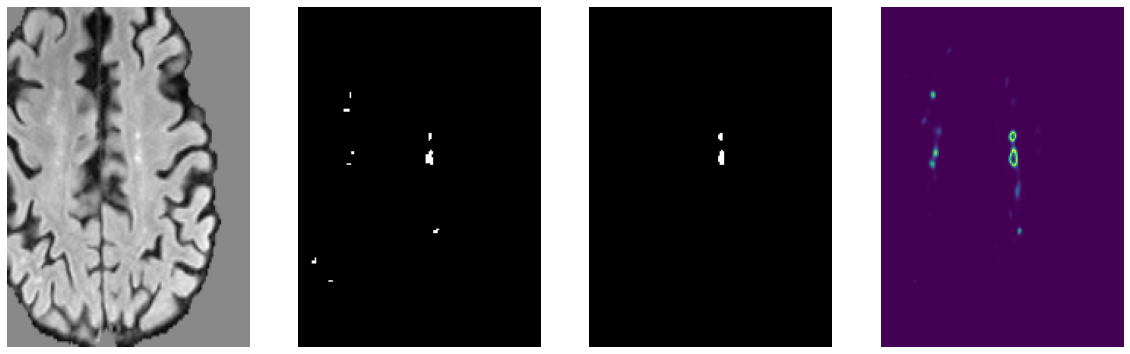

In [55]:
ind = 50
plt.figure(figsize=(20,7))
plt.subplot(1,4,1)
plt.imshow(x1[ind][0,:,:],cmap='gray'); plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(y1[ind], cmap='gray'); plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(torch.nn.functional.softmax(y_hat['logit_mean'].cpu(), dim=1).argmax(dim=1)[ind], cmap='gray'); plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(ent_map[ind]); plt.axis('off')
#print(slice_dice(y_hat['logit_mean'].cpu()[ind], y1[ind]))
plt.show()

In [60]:
torch.nn.functional.softmax(y_hat['logit_mean'].cpu()[ind], dim=0).argmax(dim=0).shape, y1[ind].shape


(torch.Size([224, 160]), torch.Size([224, 160]))

tensor(0.6958)


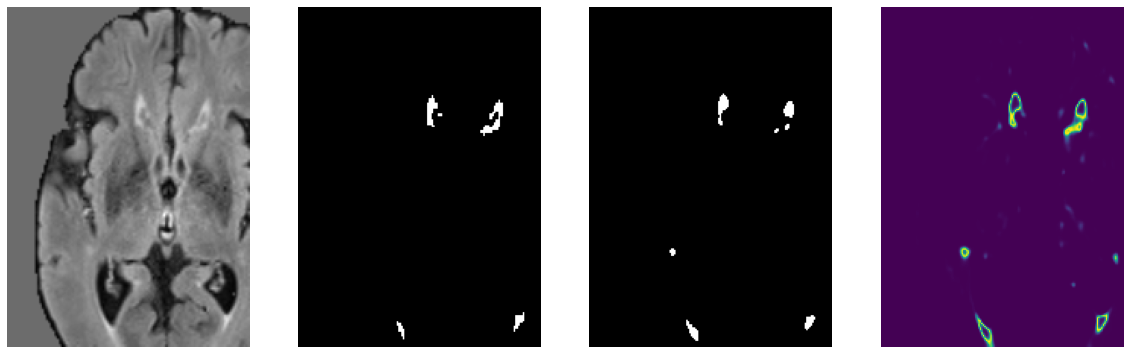

In [67]:
ind = 27#16 #27
plt.figure(figsize=(20,7))
plt.subplot(1,4,1)
plt.imshow(x1[ind][0,:,:],cmap='gray'); plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(y1[ind], cmap='gray'); plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(torch.nn.functional.softmax(y_hat['logit_mean'].cpu(), dim=1).argmax(dim=1)[ind], cmap='gray'); plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(ent_map[ind]); plt.axis('off')
print(slice_dice(y_hat['logit_mean'].cpu()[ind], y1[ind]))
plt.show()

In [ ]:
"""

THE PLAN

try doing quality control by say
- computing the pavpu and pacc gal metrics and counting how mnay uncertain patches there are in an image etc
  as that may correlate better with dice.
- predicting dice.

- If I cannot get anything working, simply move on to the interactive learning use of uncertainty. Nice.

"""

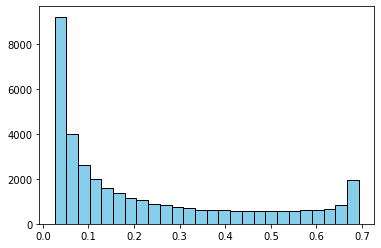

In [68]:
hist, bin_edges = torch.histogram(ent_map, ind)
plt.bar(x=bin_edges[1:-1], height=hist[1:], width=np.diff(bin_edges[1:]), align='edge', fc='skyblue', ec='black')
plt.show()

In [69]:
torch.mean(ent_map[27]), torch.mean(ent_map[16])

(tensor(0.0075), tensor(0.0231))

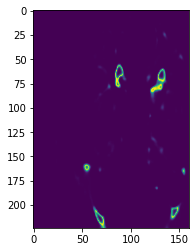

In [70]:
plt.imshow(ent_map[ind])

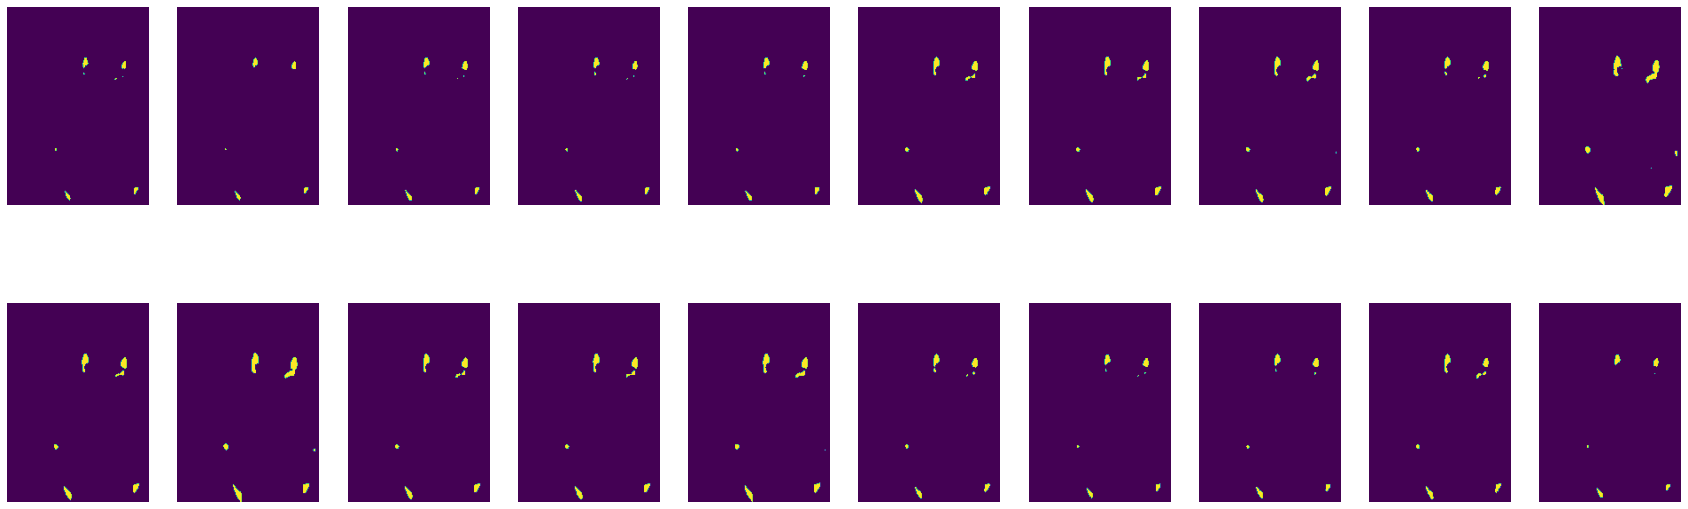

In [71]:
plt.figure(figsize=(30,10))
for i, s in enumerate(samples):
    plt.subplot(2,10,i+1)
    plt.imshow(torch.nn.functional.softmax(s.cpu(), dim=1).argmax(dim=1)[ind])
    plt.axis('off')

### Looking at Calibration

In [72]:
len(test_dataset)

358

In [73]:
with_lesion = 0
for x, y in test_dataset:
    if torch.sum(y) > 0:
        with_lesion += 1

In [74]:
with_lesion


114

In [75]:
### generate the samples that I need
with torch.no_grad():
    targets = []
    predictions = []
    masks = []
    for x, y in test_dataloader:
        outs = model(x.to(model.device))
        samples = fixed_re_parametrization_trick(outs['distribution'], 10).cpu()
        predictions.append(samples.swapaxes(0,1))
        targets.append(y.cpu())
        masks.append(x[:,1].cpu())

In [76]:
predictions = torch.cat(predictions).cpu()
targets = torch.cat(targets).cpu()
masks = torch.cat(masks)

In [77]:
### compute the entropy maps
probs = torch.nn.functional.softmax(predictions, dim=2)
pic = torch.mean(probs, dim=1)
ent_map = torch.sum(-pic * torch.log(pic+1e-30), dim=1).cpu()

In [78]:
ent_pixels = ent_map.view(-1)
mask_pixels = masks.view(-1)
ent_pixels = ent_pixels[mask_pixels == 1]

In [79]:
len(ent_pixels) / len((ent_map.view(-1)))

0.3666675759427374

In [80]:
hist, bin_edges = torch.histogram(ent_pixels)

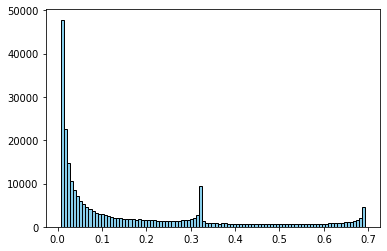

In [81]:
plt.bar(x=bin_edges[1:-1], height=hist[1:], width=np.diff(bin_edges[1:]), align='edge', fc='skyblue', ec='black')
plt.show()

In [82]:
normalized_ent = (ent_map - torch.min(ent_map)) / (torch.max(ent_map) - torch.min(ent_map))

In [83]:
predictions.shape, targets.shape

(torch.Size([358, 10, 2, 224, 160]), torch.Size([358, 224, 160]))

In [84]:
predicted_class = torch.argmax(predictions, dim=2)

In [85]:
accuracy = torch.sum(predicted_class.swapaxes(0,1) == targets, dim=0) / predicted_class.shape[1]

In [86]:
predicted_class.shape, targets.shape

(torch.Size([358, 10, 224, 160]), torch.Size([358, 224, 160]))

In [87]:
(predicted_class.swapaxes(0,1) == targets).shape

torch.Size([10, 358, 224, 160])

In [88]:
predicted_class.shape[1]

10

In [89]:
accuracy_pixels = accuracy.view(-1)[mask_pixels == 1]

In [90]:
accuracy_pixels.unique()

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000])

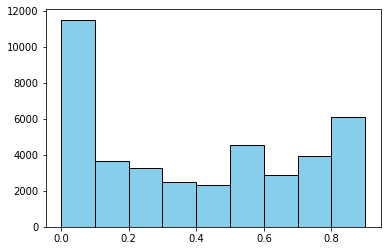

In [92]:
ahist, abin_edges = torch.histogram(accuracy_pixels, bins=10)
plt.bar(x=abin_edges[:-1-1], height=(ahist[:-1]), width=np.diff(abin_edges[:-1]), align='edge', fc='skyblue', ec='black')
plt.show()

In [166]:
# now trying to do it by patch, so patch accuracy vs patch uncertainty

In [154]:
# remove slices where there is no lesion at all
where_lesions = targets.sum(dim=(1,2)) > 0
predv2 = predictions.argmax(dim=2)[where_lesions]
ent_mapv2 = ent_map[where_lesions]
targetsv2 = targets[where_lesions]

# put samples on outer dim
predv2 = predv2.swapaxes(0,1)

samples = predv2.shape[0]
print(samples)

# unroll
window1 = 8
window2 = 8
stride = window1
ent_unrolled = ent_mapv2.unfold(1, window1, stride).unfold(2, window2, stride).reshape(-1, window1, window2)
target_unrolled = targetsv2.unfold(1, window1, stride).unfold(2, window2, stride).reshape(-1, window1, window2)
seg_unrolled = predv2.unfold(2, window1, stride).unfold(3, window2, stride).reshape(samples, -1, window1, window2)

10


In [155]:
# remove patches where there is no brain
mask_unrolled = masks[where_lesions].unfold(1, window1, stride).unfold(2, window2, stride).reshape(-1, window1, window2)
brain_patches = torch.sum(mask_unrolled, dim=(1, 2)) > 0

ent_unrolled = ent_unrolled[brain_patches]
target_unrolled = target_unrolled[brain_patches]
seg_unrolled = seg_unrolled.swapaxes(0,1)[brain_patches] # swap outer axes again to mask brain patches

In [161]:
ent_unrolled.log().max()

tensor(-0.3665)

In [173]:
from tqdm import tqdm as tqdm
results = {"p_ac":[], "p_ui":[], "pavpu":[], "t":[]}
ts = torch.arange(0, 0.7, 0.005)
#ts = torch.arange(-100, 1, 0.1)
for t in tqdm(ts):
    accuracy_threshold = 0.9
    uncertianty_threshold = t

    # compute accurate patches
    patch_accuracy = (torch.sum(seg_unrolled.swapaxes(0,1) == target_unrolled, dim=0) / samples).mean(dim=(1, 2))
    accurate_patches = patch_accuracy >= accuracy_threshold

    # compute the average uncertainty of each patch
    avg_ent = torch.mean(ent_unrolled, dim=(1,2))
    uncertain_patches = avg_ent >= uncertianty_threshold

    n_ac = torch.sum(torch.logical_and(accurate_patches, ~uncertain_patches))
    n_au = torch.sum(torch.logical_and(accurate_patches, uncertain_patches))
    n_ic = torch.sum(torch.logical_and(~accurate_patches, ~uncertain_patches))
    n_iu = torch.sum(torch.logical_and(~accurate_patches, uncertain_patches))

    results["p_ac"].append(n_ac / (n_ac + n_ic))
    results["p_ui"].append(n_iu / (n_ic + n_iu))
    results["pavpu"].append((n_ac + n_iu) / (n_ac + n_au + n_ic + n_iu))
    results["t"].append(t)
    
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 16.91it/s]


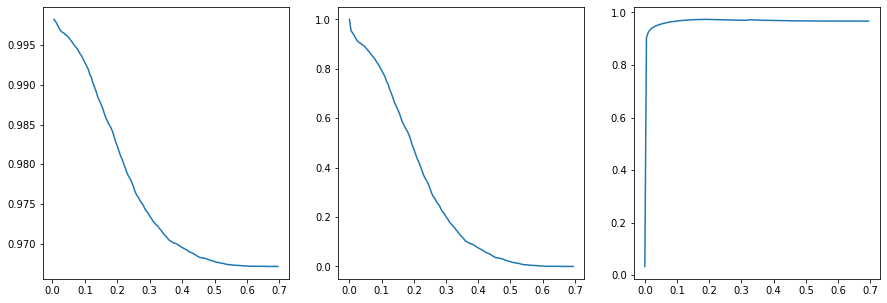

In [176]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(results["t"], results["p_ac"])
plt.subplot(1,3,2)
plt.plot(results["t"], results["p_ui"])
plt.subplot(1,3,3)
plt.plot(results["t"], results["pavpu"]);
#ts

In [180]:
# using the results from above
outv2 = predictions[where_lesions]

In [185]:
outv2[i].shape

torch.Size([10, 2, 224, 160])

In [218]:
dices = []
uncert_patches = []
accuracy_threshold = 0.9
uncertianty_threshold = 0.05
for i in tqdm(range(outv2.shape[0])):
    dice = slice_dice(outv2[i].mean(dim=0), targetsv2[i])
    ient_unrolled = ent_mapv2[i].unfold(0, window1, stride).unfold(1, window2, stride).reshape(-1, window1, window2)
    itarget_unrolled = targetsv2[i].unfold(0, window1, stride).unfold(1, window2, stride).reshape(-1, window1, window2)
    iseg_unrolled = predv2[:,i].unfold(1, window1, stride).unfold(2, window2, stride).reshape(samples, -1, window1, window2)
    
    # compute accurate patches
    ipatch_accuracy = (torch.sum(iseg_unrolled == itarget_unrolled, dim=0) / samples).mean(dim=(1, 2))
    iaccurate_patches = ipatch_accuracy >= accuracy_threshold

    # compute the average uncertainty of each patch
    iavg_ent = torch.mean(ient_unrolled, dim=(1,2))
    iuncertain_patches = iavg_ent >= uncertianty_threshold
    
    num_uncert_patches = torch.sum(ent_mapv2[i])#torch.sum(iuncertain_patches)
    
    dices.append(dice)
    uncert_patches.append(num_uncert_patches)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 267.36it/s]


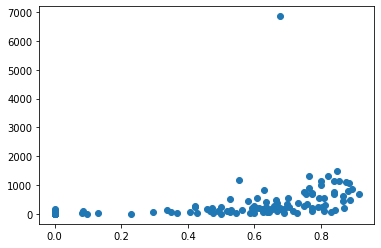

In [219]:
plt.scatter(dices, uncert_patches)

In [220]:
"""

The story to sell is

we can correlate pixel accuracy with uncertianty quite well, however, we cannot do quality control so easily
as accuracy and dice do not correlate.

So, we should train a separate DICE prediction network, and use that for quality control.

Okay, instead, what I am going to do is try interactive learning with the uncertainty map to imporve predictions.
Nice.
"""

716

In [98]:
torch.sum(brain_patches) / len(brain_patches)

tensor(0.7471)

In [99]:
# compute the average entropy of each patch
avg_ent = torch.var(ent_unrolled, dim=(1,2))

In [100]:
# compute the accuracy of each patch
patch_accuracy = (torch.sum(seg_unrolled.swapaxes(0,1) == target_unrolled, dim=0) / samples).mean(dim=(1, 2))

In [101]:
avg_ent[87] = 0.01

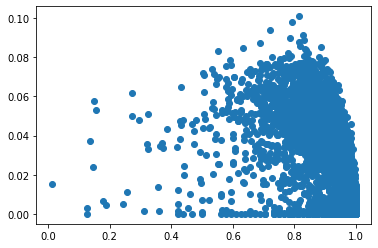

In [102]:
plt.scatter(patch_accuracy, avg_ent)

In [373]:
torch.argmax(avg_ent)

tensor(20)

In [374]:
torch.corrcoef(torch.stack([patch_accuracy, avg_ent]))

tensor([[ 1.0000, -0.8169],
        [-0.8169,  1.0000]])

### Quality control plot

In [392]:
# remove slices where there is no lesion at all
where_lesions = targets.sum(dim=(1,2)) > 0
predictionsv2 = predictions[where_lesions]
predv2 = predictionsv2.argmax(dim=2)
ent_mapv2 = ent_map[where_lesions]
targetsv2 = targets[where_lesions]

In [ ]:
# mean dices


In [381]:
pixel_accuracy = torch.sum(predv2.swapaxes(0,1) == targetsv2, dim=0) / samples
avg_accuracy = torch.mean(pixel_accuracy, dim=(1,2))

In [384]:
avg_ent = torch.mean(ent_mapv2, dim=(1,2))

In [388]:
torch.argmax(avg_ent)

tensor(87)

In [389]:
avg_ent[87] = 0.01

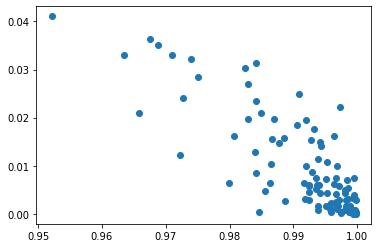

In [390]:
plt.scatter(avg_accuracy, avg_ent)

In [439]:
torch.corrcoef(torch.stack([avg_accuracy, avg_ent]))

tensor([[ 1.0000, -0.8198],
        [-0.8198,  1.0000]])

In [413]:
dices = []
for i in tqdm(range(targetsv2.shape[0])):
    sample_dices = []
    for s in range(samples):
        sample_dices.append(ind_slice_dice(predictionsv2[i,s], targetsv2[i]))
    dices.append(sample_dices)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:03<00:00, 35.12it/s]


In [415]:
avg_dices = torch.mean(torch.Tensor(dices), dim=1)

In [417]:
torch.where(avg_dices == 0)

(tensor([ 25,  28,  34,  36,  38,  51,  54,  56,  63, 107]),)

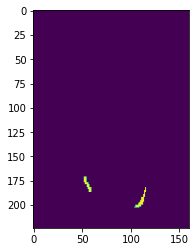

In [419]:
plt.imshow(targetsv2[28])

In [406]:
def ind_slice_dice(y_hat, y_true):
    y_hat = torch.nn.functional.softmax(y_hat, dim=0).argmax(dim=0)
    
    if torch.sum(y_hat) == 0 and torch.sum(y_true) == 0:
        return "n/a"
    
    numerator = torch.sum(2 * y_hat * y_true)
    denominator = torch.sum(y_hat + y_true)
    return numerator / (denominator + 1e-8)

In [431]:
true_volume = torch.sum(targetsv2, dim=(1,2))

In [433]:
true_volume

tensor([ 207,  142, 1238,  140,  250, 1693, 3088,   98,  111,  918,  204, 2865,
        1140,  341,    8,  899,   11,  671,  417,  898, 1115, 1388,   47,   40,
         130,    6,   60,   65,  115,  763, 1684, 1018,  569,  373,   12, 1067,
          10,   32,   17, 2585,  320, 2521, 4571,  176, 4312,  405,  343,  336,
         153,   89, 1144,   22,   55,  794,   12, 1385,   14,  181,   12,   82,
         103,   78,   26,    4,   61, 1366,   14,  820,   10,   70, 1679, 5383,
          54,  116,  905,   15,  100,   55,  389,  616,   28,  203,  158,   56,
          24,  447,  152,  182,   53, 1060,    6,  269,  258, 1581,   29,  533,
          20,   22,   24,  382,  951,  498,   86,  254,  357,  535,  160,   38,
         416,   32])

In [412]:
ind_slice_dice(predictionsv2[0,0], targetsv2[0])

tensor(0.5939)

In [400]:
predictionsv2[0,0].shape

torch.Size([2, 224, 160])

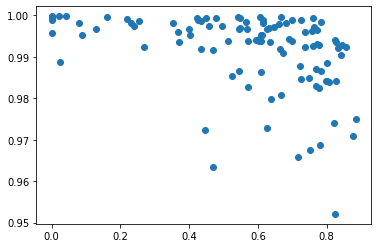

In [436]:
plt.scatter(avg_dices, avg_accuracy)